### MSc in CSTE, CIDA option's Advanced Python & Advanced Java Assignment

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as plt3d
%matplotlib widget
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tabulate import tabulate

class MultiLinearRegression:

    def __init__(self, filename, predColIndexes, targetColIndex, iterations, learningRate):
        # Read data from file:
        self.filename = filename

        # Load data, remove first row (columns names), remove nan values and normalize it:
        self.columnsNames = np.genfromtxt(self.filename, delimiter=',', dtype=str, max_rows=1)  # Save columns names for future plotting
        self.targetIndex, self.predIndexes = targetColIndex, predColIndexes                     # Save target and prediction columns indexes for future plotting and splitting data
        self.data = np.genfromtxt(self.filename, delimiter=',', skip_header=1)                  # Skip first row, which is columns names
        self.data = self.data[~np.isnan(self.data).any(axis=1)]                                 # Remove nan values
        self.data = preprocessing.scale(self.data)                                              # Normalize data
        self.data = self.data[~(np.abs(self.data) > 3).any(axis=1)]                             # Remove extreme values

        # Split data into features and target, and add a column of ones to features:
        self.Y = self.data[:, targetColIndex]           # Assign target column to Y, using the target column index
        self.data = self.data[:, predColIndexes]        # Assign features columns to X, using the features columns indexes
        self.data = np.insert(self.data, 0, 1, axis=1)  # Add a column of ones to X at the beginning, so that the matrix multiplication between X and theta is possible

        # Split data into train and test randomly:
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.data, self.Y, test_size=0.2, random_state=23)

        # Number of features and observations:
        self.r = len(self.data[0])  # number of features
        self.n = len(self.data)  # number of observations

        # Initialize thetas, hypothesis, iterations and learning rate:
        self.thetas = np.zeros(self.r)  # Initialize thetas
        self.hypothesis = np.zeros(self.n)  # Initialize hypothesis
        self.iterations = iterations    # Keep in memory iterations amount requested upon initialization
        self.learningRate = learningRate    # Keep in memory learning rate requested upon initialization

        # Cost:
        self.cost = []  # Initialize cost

    # Plot train and test data in 3D in different colors and different plots:
    def plotTrainAndTestData(self):
        fig = plt.figure(figsize=(15, 10))
        fig.suptitle(self.filename+' : Train and Test Data')
        fig.subplots_adjust(top=1.10)   # Adjust the distance between the title and the plots, as initially the title is too far from the plots
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.scatter3D(self.X_train[:, 1], self.X_train[:, 2], self.Y_train, c='red', label='Train Data (Proportion=0.8)', marker='.')
        ax.set_zlabel(self.columnsNames[self.targetIndex])
        ax.legend()
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.scatter3D(self.X_test[:, 1], self.X_test[:, 2], self.Y_test, c='blue', label='Test Data (Proportion=0.2)', marker='.')
        ax.set_zlabel(self.columnsNames[self.targetIndex])
        ax.legend()
        plt.show()

    # Plot each predictor against the target in different colors:
    def plotPredictorsVsTarget(self):
        fig, axs = plt.subplots(1, self.r-1, figsize=(15, 5))
        colors = ['red', 'green', 'blue', 'orange', 'black', 'orange', 'purple', 'brown', 'pink', 'gray']
        # In order to skip the first column of ones, the loop starts from 1 and end at self.r
        for i in range(1, self.r):
            axs[i-1].scatter(self.data[:, i], self.Y, c=colors[i-1], marker='.')
            axs[i-1].set_xlabel(self.columnsNames[i])
            axs[i-1].set_ylabel(self.columnsNames[-1])
            axs[i-1].set_title('('+self.columnsNames[self.targetIndex]+') vs ('+self.columnsNames[self.predIndexes[i-1]]+')')
        fig.suptitle(self.filename+' : Target ('+self.columnsNames[self.targetIndex]+') vs Multiples Predictors')
        fig.subplots_adjust(top=0.85)
        plt.show()

    # Plot y test vs y predicted:
    def plotYTestVsYPredicted(self):
        Y_pred = np.dot(self.X_test, self.thetas)
        Y_test = self.Y_test
        Y_test, Y_pred = zip(*sorted(zip(Y_test, Y_pred)))
        observations = np.arange(1, len(Y_pred)+1)
        plt.scatter(observations, Y_pred, label='Y Predicted', color='blue', marker='.')
        plt.scatter(observations, Y_test, label='Y Test', color='red', marker='.')
        plt.xlabel('Observations')
        plt.ylabel(self.columnsNames[self.targetIndex])
        plt.legend()
        plt.title(self.filename+' : Y Test vs Y Predicted')
        plt.show()

    # Gradient descent:
    def gradientDescent(self):
        cost = []
        for i in range(self.iterations):
            self.hypothesis = np.dot(self.X_train, self.thetas) # Calculate hypothesis (h(x) = theta0 + theta1*x1 + theta2*x2 + ... + thetar*xr)
            self.thetas -= self.learningRate * (2 / self.n) * np.dot(self.X_train.T, self.hypothesis - self.Y_train)    # Update thetas using the formula
            cost.append(1 / self.n * np.sum((self.hypothesis - self.Y_train) ** 2)) # Calculate cost and add it to the cost list
        self.cost = cost    # Keep in memory the cost list. Each mlr object has its own cost list after computing gradient descent
        return cost

    # Gradient descent while thetas successive differences are greater than 0.0001:
    def gradientDescentUntilConvergence(self):
        cost = []   # Initialize cost list
        thetas = np.ones(self.r)                                # Initialize thetas to ones, so that the while loop can start (real thetas are initialized as zeros)
        while np.sum(np.abs(thetas - self.thetas)) > 0.0001:    # Differently from previous method, we compare thetas previous and current values and decide when to stop the loop.
            thetas = np.copy(self.thetas)                       # Keep in memory thetas' previous values
            self.hypothesis = np.dot(self.X_train, self.thetas) # Calculate hypothesis (h(x) = theta0 + theta1*x1 + theta2*x2 + ... + thetar*xr)
            self.thetas -= self.learningRate * (2 / self.n) * np.dot(self.X_train.T, self.hypothesis - self.Y_train)    # Update thetas using the formula
            cost.append(1 / self.n * np.sum((self.hypothesis - self.Y_train) ** 2))   # Calculate cost and add it to the cost list
        self.cost = cost                                        # Keep in memory the cost list. Each mlr object has its own cost list after computing the gradient descent
        return cost

    # Plot cost:
    def plotCost(self):
        plt.plot(self.cost, label='cost evolution, itr=' + str(self.iterations)+', eta='+str(self.learningRate))    # Plot cost evolution
        plt.title('\''+self.filename+'\'')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.legend()
        plt.show()

    # Compute R2 using the formula:
    def computeR2(self):
        return 1 - np.sum(np.square(self.Y_test - np.dot(self.X_test, self.thetas))) / np.sum(np.square(self.Y_test - np.mean(self.Y_test)))

    # Print self-computed R2:
    def printR2(self):
        print('Computed R2 for the ' + self.filename + ' data, in percentage: ', str(np.round(self.computeR2()*100, 2)), ' %')

    # Compute R2 using SKLearn's LinearRegression:
    def computeSKLearnR2(self):
        lr = LinearRegression() # Create a LinearRegression object
        lr.fit(self.X_train, self.Y_train)  # Fit the model using the training data
        return lr.score(self.X_test, self.Y_test)   # Compute the R2 using the test data

    # Print SKLearn-computed R2:
    def printSKLearnR2(self):
        print('SKLearn R2 for the ' + self.filename + ' data, in percentage: ', str(np.round(self.computeSKLearnR2()*100, 2)), ' %')

In [182]:
# Plot multiples cost in one plot with different learning rates and different colors:
def plotMultipleCostsOnePlot(filename, predColIndexes, targetColIndex, learningRates, iterations):
    colors = ['red', 'blue', 'orange', 'grey', 'purple']
    for i in range(len(learningRates)):
        mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations, learningRates[i])
        mlr.gradientDescent()
        plt.plot(mlr.cost, color=colors[i], label='eta='+str(learningRates[i]))
    plt.title('\''+filename+'\'')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()

# Plot multiple plots in one figure:
def plotMultipleCostsSubplots(filename, predColIndexes, targetColIndex, iterations, learningRates):
    fig, axs = plt.subplots(4, 4)
    fig.suptitle(filename+' : Cost for various iterations and learning rates values.')
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            axs[i, j].plot(mlr.cost, label='itr=' + str(iterations[j]) + ', eta=' + str(learningRates[i]))
            axs[i, j].set_xlabel('Iterations')
            axs[i, j].set_ylabel('Cost')
            axs[i, j].text(0.35, 0.25, 'R2: ' + str(round(mlr.computeR2()*100, 2))+' %', horizontalalignment='center',
                           verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].legend()
    fig.set_size_inches(16.5, 10.5)
    fig.subplots_adjust(top=0.93)
    plt.show()

# 3D plot of R2 for various iterations and learning rates values with contour plot:
def plot3D(filename, predColIndexes, targetColIndex, iterations, learningRates):
    fig = plt.figure()
    ax = plt3d.Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Learning rate')
    ax.set_zlabel('R2')
    ax.set_title(filename)
    X, Y = np.meshgrid(iterations, learningRates)
    Z = np.zeros((len(learningRates), len(iterations)))
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            Z[i, j] = mlr.computeR2()
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cool', edgecolor='black')
    ax.view_init(30, 230)
    ax.text2D(0.22, 0.95, 'Computation of R**2 for various iterations and eta values', transform=ax.transAxes)
    plt.show()


# Table of R2 for various iterations and learning rates values using tabulate:
def tableOfR2(filename, predColIndexes, targetColIndex, iterations, learningRates):
    table = []
    for i in range(len(learningRates)):
        row = [learningRates[i]]
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            row.append(round(mlr.computeR2(), 4))
        table.append(row)
    print(filename+' : Table of R2 for various iterations and learning rates values:')
    print(tabulate(table, headers=['LR \ ITR'] + iterations, tablefmt='fancy_grid'))

# Print max R2 for various iterations and learning rates values, at .001 % precision:
def printMaxR2(filename, predColIndexes, targetColIndex, iterations, learningRates):
    maxR2 = 0
    maxR2Index = [0, 0]
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            if np.abs(mlr.computeR2() - maxR2) > 0.00001:
                maxR2 = mlr.computeR2()
                maxR2Index = [i, j]
    print(filename+' : Max R2: ', np.round(maxR2*100,2), ' % (for itr=', iterations[maxR2Index[1]], ', and eta=', learningRates[maxR2Index[0]], ')')


# Table of iterations needed for convergence for various learning rates values using tabulate:
def tableOfIterations(filename, predColIndexes, targetColIndex, learningRates):
    table = []
    for i in range(len(learningRates)):
        mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, 100000, learningRates[i]) # Iterations parameter is not important here
        mlr.gradientDescentUntilConvergence()
        table.append([learningRates[i], len(mlr.cost)])
    print(filename+' : Table of iterations needed for convergence, for various learning rates values:')
    print(tabulate(table, headers=['Learning rate', 'Iterations'], tablefmt='fancy_grid'))

# Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values using tabulate:
def tableOfR2Diff(filename, predColIndexes, targetColIndex, iterations, learningRates):
    table = []
    for i in range(len(learningRates)):
        row = [learningRates[i]]
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            row.append(str(abs(round((mlr.computeR2() - mlr.computeSKLearnR2())*100, 2))) + ' %')
        table.append(row)
    print(filename+' : Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values:')
    print(tabulate(table, headers=['LR \ ITR'] + iterations, tablefmt='fancy_grid'))

# Find the best combination of iterations and learning rate values to get an R2 as close as possible to SKlearn R2:
def findOptimalCombinationForEquivalentR2(filename, predColIndexes, targetColIndex, iterations, learningRates):
    optimalCombination = [1000000, 0.00001]
    r2, sklearnR2, diff = 0, 0, 100
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[len(iterations)-1-i], learningRates[len(learningRates)-1-j])
            mlr.gradientDescent()
            if(abs((mlr.computeR2() - mlr.computeSKLearnR2())/(mlr.computeSKLearnR2()))<0.01 and iterations[len(iterations)-1-i] < optimalCombination[0] and learningRates[len(learningRates)-1-j] > optimalCombination[1]):    # To calculate the relative difference, we divide by SKlearn R2 as it is the obligatory maximum.
                optimalCombination = [iterations[len(iterations)-1-i], learningRates[len(learningRates)-1-j]]
                r2 = mlr.computeR2()
                sklearnR2 = mlr.computeSKLearnR2()
                diff = abs(r2 - sklearnR2)
    return optimalCombination[0], optimalCombination[1], r2, sklearnR2, diff


In [167]:
# Files and their predictor and target columns indexes:
files = [['dataEnergy.csv', [0, 1, 2, 3], 4], ['dataLoans.csv', [1, 4], 0]]

Throughout the project, I will use the files array to iterate over the files, and the predColIndexes and targetColIndex variables to iterate over the predictor and target columns.
It will make the code more readable and easier to maintain, as well as for the for loops because this will allow to replicate the same code for each dataset, without having to write it again. In files, each element is an array containing the filename, the predictor columns indexes, and the target column index.

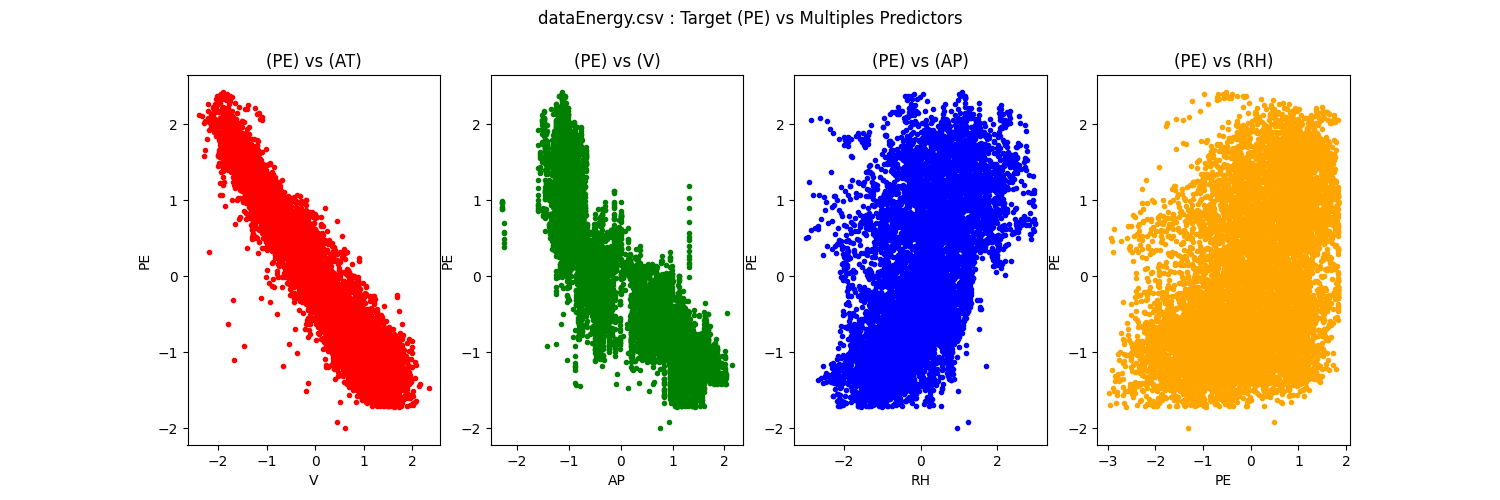

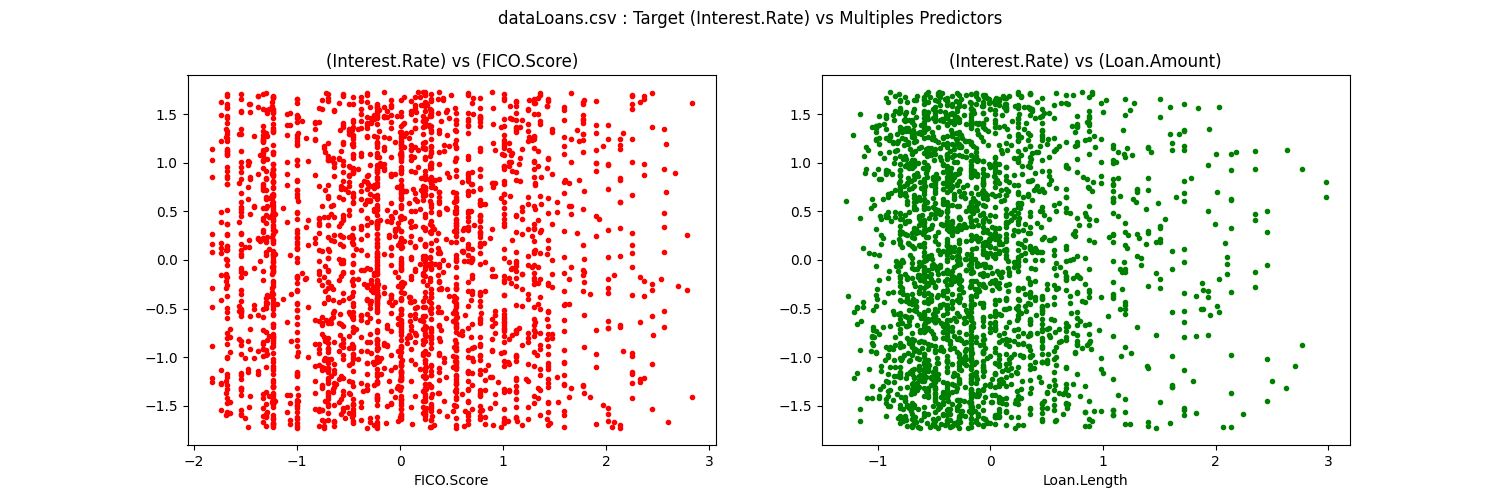

In [162]:
# Plot each predictor against the target in different colors:
for file in files :
    # Create a multi linear regression object, without computing the gradient descent:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    # Plot each predictor against the target in different colors:
    mlr.plotPredictorsVsTarget()

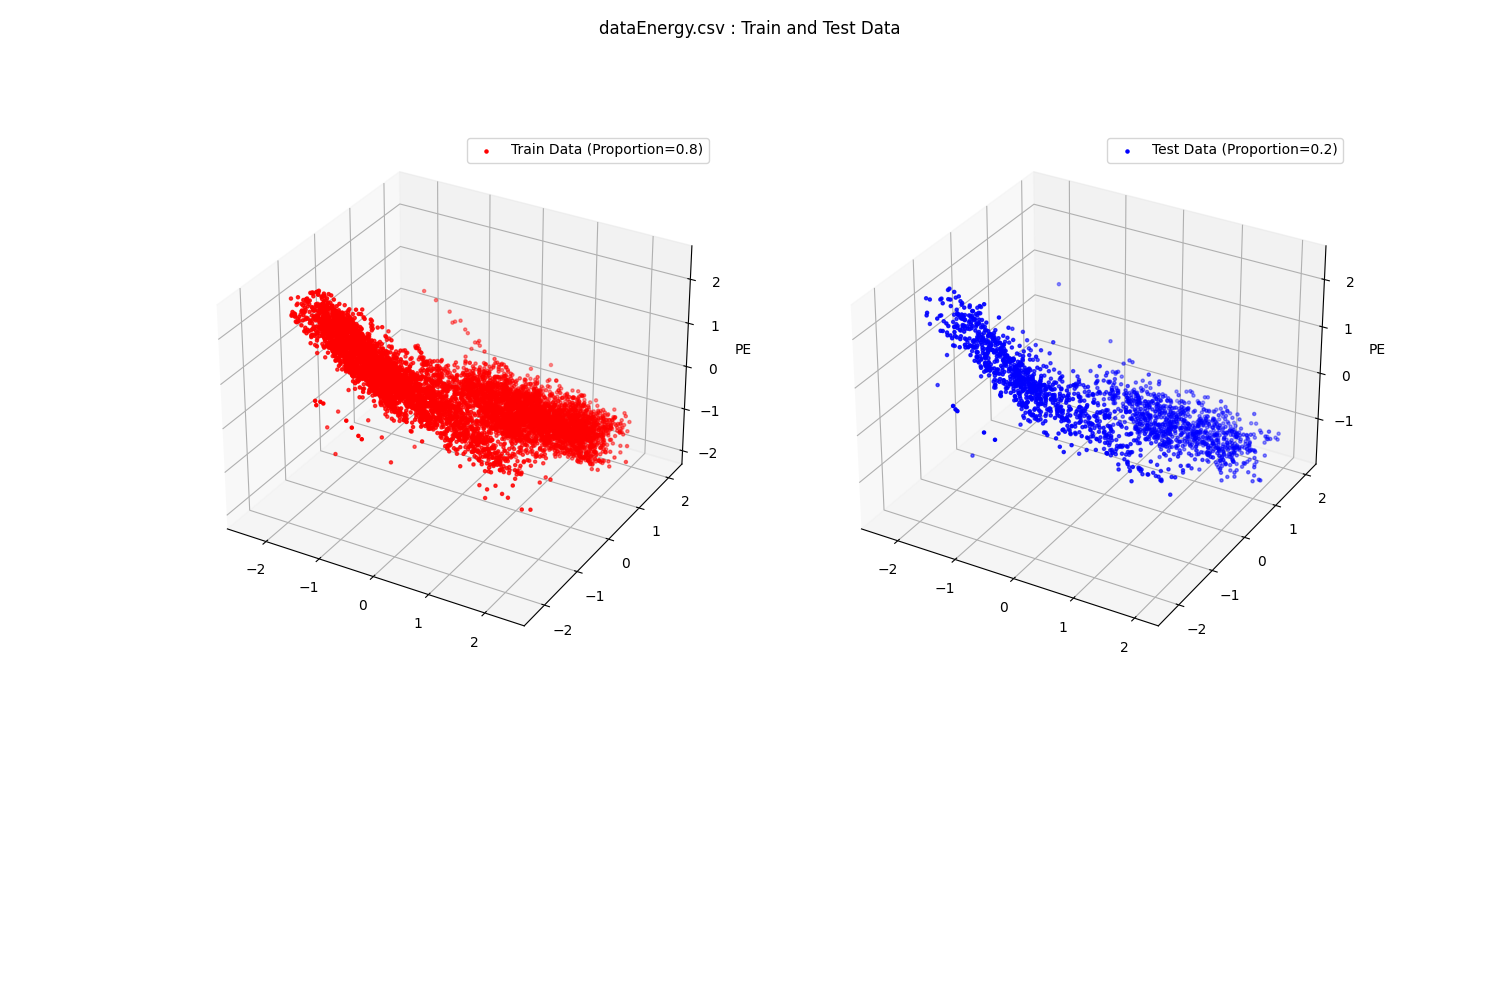

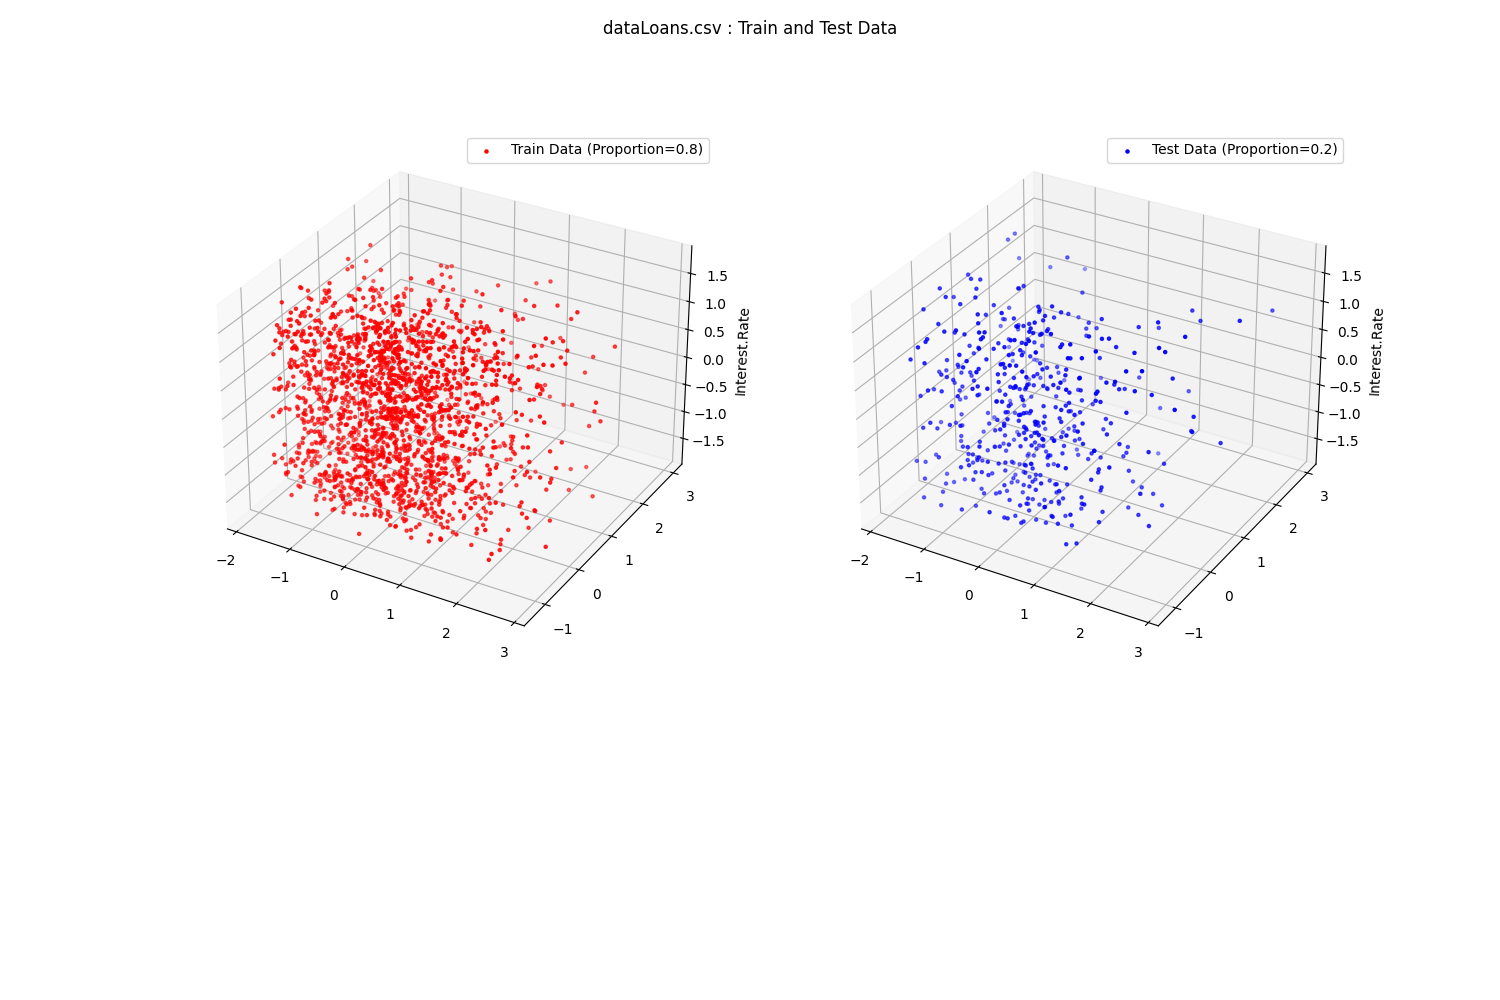

In [163]:
for file in files:
    # Plot train and test data in 3D in different colors and different plots:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.plotTrainAndTestData()

In [164]:
for file in files :
    # Plot Y pred vs Y target for various iterations and learning rates values:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    mlr.plotYTestVsYPredicted()

ValueError: s must be a scalar, or float array-like with the same size as x and y

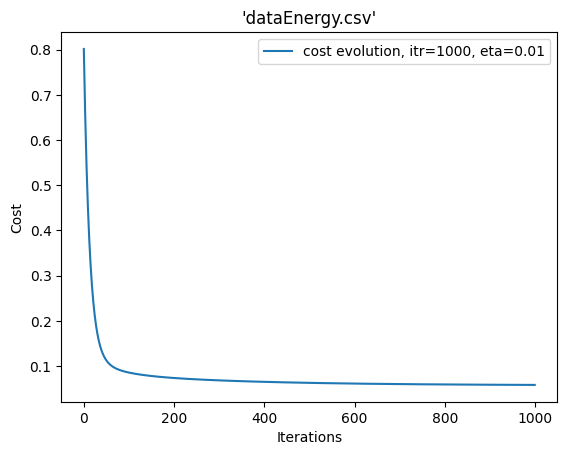

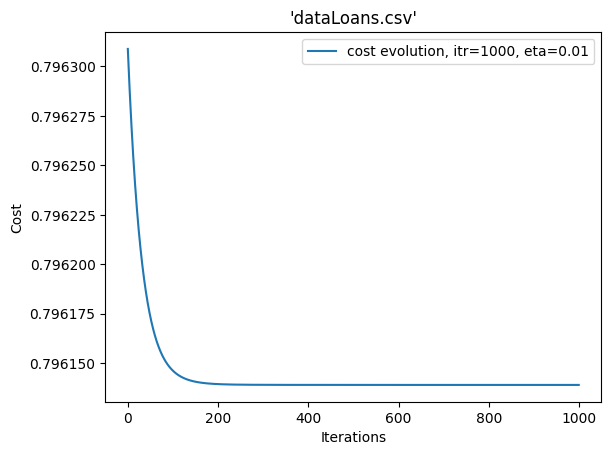

In [128]:
for file in files:
    # Create MultiLinearRegression object by referencing the data, predictor and target columns; as well as the number of iterations and learning rate:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    # Compute gradient descent with previously given number of iterations and learning rate:
    mlr.gradientDescent()
    # Plot the cost function:
    mlr.plotCost()

In [129]:
for file in files:
    # Create MultiLinearRegression object by referencing the data, predictor and target columns; as well as the number of iterations and learning rate:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    # Compute gradient descent with previously given number of iterations and learning rate:
    mlr.gradientDescent()
    # Print its R2:
    mlr.printR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.49  %
Computed R2 for the dataLoans.csv data, in percentage:  0.1  %


It makes sense that the R2 for the second dataset is lower, nearly null; and that the cost is converging, yes, but not to zero.

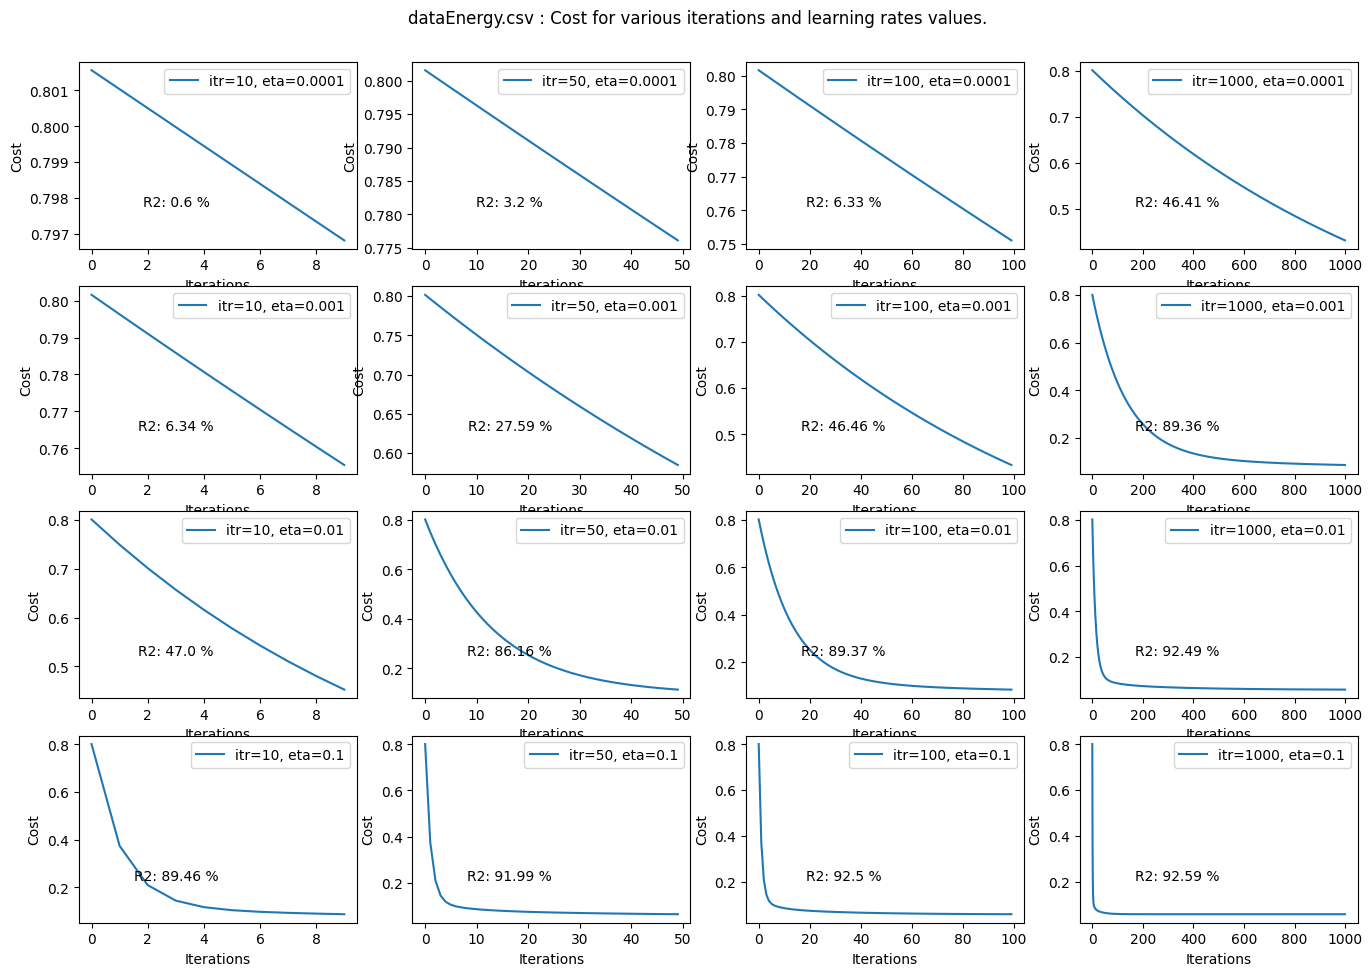

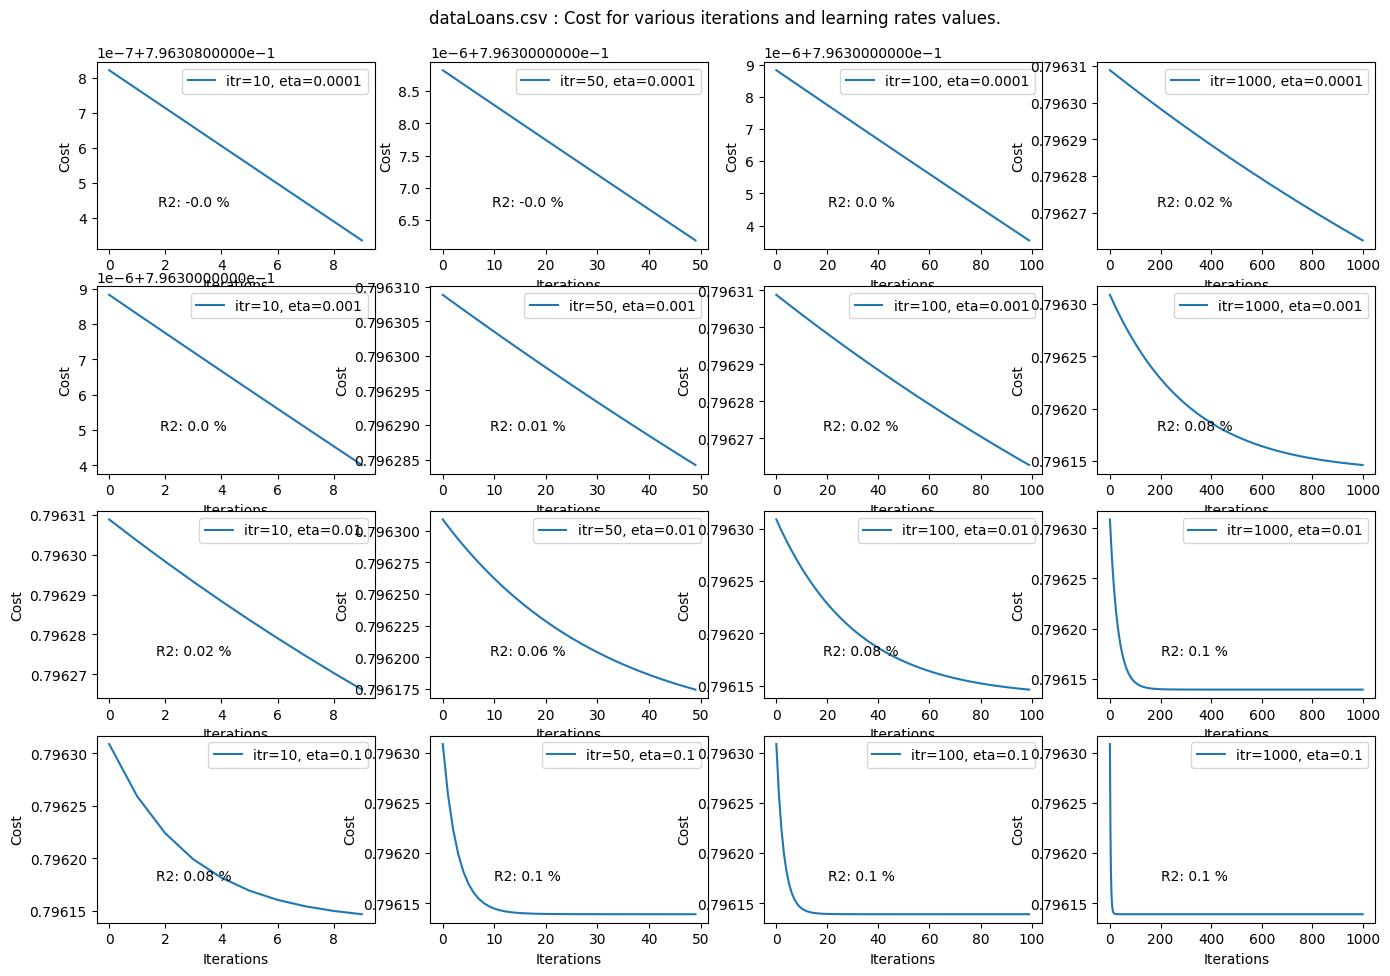

In [130]:
for file in files:
    # Plot cost for various iterations and learning rates values:
    plotMultipleCostsSubplots(file[0], file[1], file[2], [10, 50, 100, 1000], [0.0001, 0.001, 0.01, 0.1])

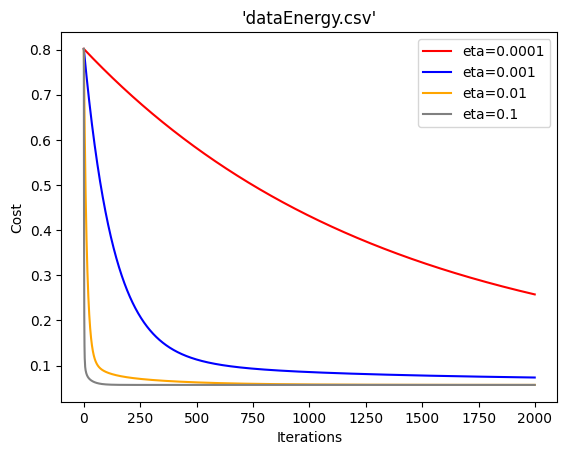

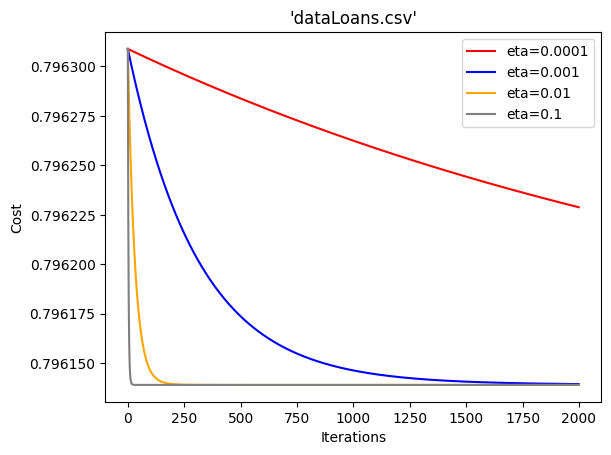

In [131]:
for file in files:
    plotMultipleCostsOnePlot(file[0], file[1], file[2], [0.0001, 0.001, 0.01, 0.1], 2000)

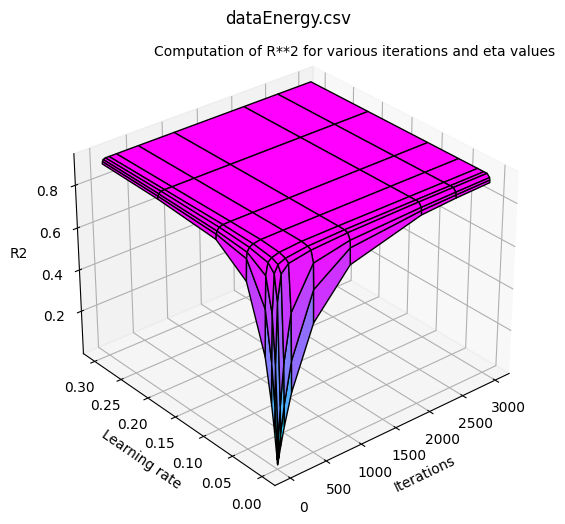

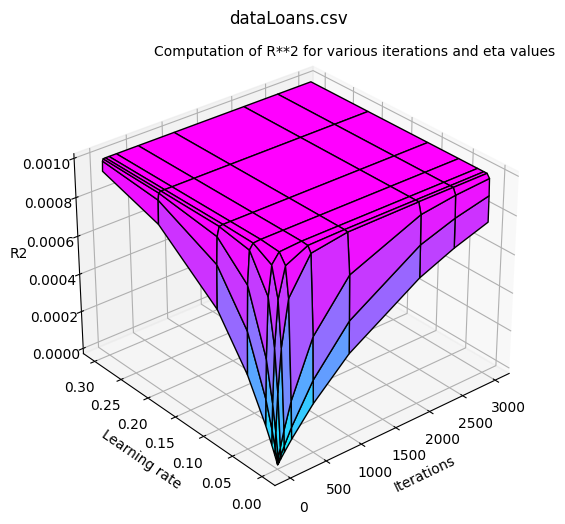

In [132]:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    # Plot R2 for various iterations and learning rates values:
    plot3D(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500, 3000],
           [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [133]:
# Compute max R2 for various iterations and learning rates values, at .01 % precision:
for file in files:
    printMaxR2(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500, 3000], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

dataEnergy.csv : Max R2:  92.59  % (for itr= 200 , and eta= 0.3 )
dataLoans.csv : Max R2:  0.1  % (for itr= 20 , and eta= 0.3 )


In [134]:
# Table of R2 for various iterations and learning rates values:
for file in files:
    tableOfR2(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of R2 for various iterations and learning rates values:
╒════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│   LR \ ITR │      5 │     10 │     20 │     50 │    100 │    200 │    500 │   1000 │   2000 │   2500 │
╞════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│     0.0003 │ 0.0093 │ 0.0191 │ 0.0383 │ 0.0936 │ 0.1776 │ 0.3193 │ 0.5932 │ 0.7848 │ 0.8739 │ 0.8847 │
├────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│     0.0005 │ 0.0158 │ 0.032  │ 0.0634 │ 0.1507 │ 0.2757 │ 0.4643 │ 0.7427 │ 0.8603 │ 0.8936 │ 0.8988 │
├────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│     0.001  │ 0.032  │ 0.0634 │ 0.1228 │ 0.2759 │ 0.4646 │ 0.682  │ 0.8603 │ 0.8936 │ 0.9075 │ 0.911  │
├────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────

In [135]:
# Table of iterations needed for convergence for various learning rates values:
for file in files:
    tableOfIterations(file[0], file[1], file[2], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of iterations needed for convergence, for various learning rates values:
╒═════════════════╤══════════════╕
│   Learning rate │   Iterations │
╞═════════════════╪══════════════╡
│          0.0003 │         2717 │
├─────────────────┼──────────────┤
│          0.0005 │         2737 │
├─────────────────┼──────────────┤
│          0.001  │         3704 │
├─────────────────┼──────────────┤
│          0.005  │         2595 │
├─────────────────┼──────────────┤
│          0.01   │         1715 │
├─────────────────┼──────────────┤
│          0.02   │         1067 │
├─────────────────┼──────────────┤
│          0.05   │          537 │
├─────────────────┼──────────────┤
│          0.1    │          309 │
├─────────────────┼──────────────┤
│          0.2    │          175 │
├─────────────────┼──────────────┤
│          0.3    │          124 │
╘═════════════════╧══════════════╛


dataLoans.csv : Table of iterations needed for convergence, for various learning rates values:
╒═

In [136]:
# Compute own R2 and SKLearn R2, and print both of them:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    mlr.printR2()
    mlr.printSKLearnR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.49  %
SKLearn R2 for the dataEnergy.csv data, in percentage:  92.59  %
Computed R2 for the dataLoans.csv data, in percentage:  0.1  %
SKLearn R2 for the dataLoans.csv data, in percentage:  0.1  %


Since it seems there's a difference between the computed R2 and the SKLearn R2 for 1000 iterations and a learning rate of 0.01, it may be interesting to table difference between both R2 for various iterations and learning rates values.

In [137]:
# Table of difference between computed R2 and R2 using SKLearn, for various iterations and learning rates values:
for file in files:
    tableOfR2Diff(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000],
                  [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values:
╒════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════╕
│   LR \ ITR │ 5       │ 10      │ 20      │ 50      │ 100     │ 200     │ 500     │ 1000    │ 2000   │
╞════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╡
│     0.0003 │ 91.66 % │ 90.68 % │ 88.75 % │ 83.23 % │ 74.83 % │ 60.66 % │ 33.27 % │ 14.11 % │ 5.2 %  │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┤
│     0.0005 │ 91.0 %  │ 89.39 % │ 86.25 % │ 77.52 % │ 65.02 % │ 46.16 % │ 18.32 % │ 6.56 %  │ 3.23 % │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┤
│     0.001  │ 89.39 % │ 86.24 % │ 80.3 %  │ 64.99 % │ 46.13 % │ 24.38 % │ 6.55 %  │ 3.23 %  │ 1.83 % │
├────────────┼─────────┼─────────┼─────────┼─

With our implementation of the gradient descend, it seems that the difference between our R2 and SKLearn's R2 is very small, almost negligable, making our implementation successful.
Additionally, it seems that it takes a certain amount of iterations (and a certain learning rate) in order to compute an R2 significantly close to SKLearn's R2.
If one wanted to go above and beyond, they could try to find the optimal number of iterations and learning rate, in order to compute the best R2 possible.

In [138]:
# Compute own R2 and SKLearn R2, and print both of them, with interesting values:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 500, 0.1)
    mlr.gradientDescent()
    mlr.printR2()
    mlr.printSKLearnR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.59  %
SKLearn R2 for the dataEnergy.csv data, in percentage:  92.59  %
Computed R2 for the dataLoans.csv data, in percentage:  0.1  %
SKLearn R2 for the dataLoans.csv data, in percentage:  0.1  %


In [184]:
# Find the best combination of iterations and learning rate values to get an R2 as close as possible to SKlearn R2:
iterations = np.array([5*i for i in range(1,30)])
learningRates = np.array([(1-0.05*i) for i in range(1,20)])
for file in files:
    optItr, optLr, r2, skr2, diff = findOptimalCombinationForEquivalentR2(file[0], file[1], file[2], iterations, learningRates)
    print('Optimal combination for file ', file[0], ' is: ', optItr, ' iterations and and learning rate of ', optLr, '.\n The self-computed R2 was ', r2, ', the SKLearn R2 was ', skr2, ' and the difference between both was ', diff, '.\n')

Optimal combination for file  dataEnergy.csv  is:  100  iterations and and learning rate of  0.5 .
 The self-computed R2 was  0.9258511268539293 , the SKLearn R2 was  0.9258618334261925  and the difference between both was  1.0706572263208258e-05 .

Optimal combination for file  dataLoans.csv  is:  55  iterations and and learning rate of  0.95 .
 The self-computed R2 was  0.0010019297384747938 , the SKLearn R2 was  0.0010019297384747938  and the difference between both was  0.0 .



### CQFD